In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225]) 
])


In [3]:
dataset = datasets.ImageFolder(root='C:/Users/HP/Desktop/dl_project/Celebrity_Recognition/dataset/cropped/', transform=transform)


In [4]:
total_size = len(dataset)

train_ratio = 0.6
val_ratio = 0.3
test_ratio = 0.1

train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size  

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [5]:
len(train_loader) * 32

832

In [6]:
len(test_loader) * 32

160

In [7]:
len(val_loader) * 32 

416

In [8]:
print(dataset.classes)        
print(dataset.class_to_idx)  

['Angelina Jolie', 'Brad Pitt', 'Denzel Washington', 'Hugh Jackman', 'Jennifer Lawrence', 'Johnny Depp', 'Kate Winslet', 'Leonardo DiCaprio', 'Megan Fox', 'Natalie Portman', 'Nicole Kidman', 'Robert Downey Jr', 'Sandra Bullock', 'Scarlett Johansson', 'Tom Cruise', 'Tom Hanks', 'Will Smith']
{'Angelina Jolie': 0, 'Brad Pitt': 1, 'Denzel Washington': 2, 'Hugh Jackman': 3, 'Jennifer Lawrence': 4, 'Johnny Depp': 5, 'Kate Winslet': 6, 'Leonardo DiCaprio': 7, 'Megan Fox': 8, 'Natalie Portman': 9, 'Nicole Kidman': 10, 'Robert Downey Jr': 11, 'Sandra Bullock': 12, 'Scarlett Johansson': 13, 'Tom Cruise': 14, 'Tom Hanks': 15, 'Will Smith': 16}


In [9]:
import matplotlib.pyplot as plt
import numpy as np

In [10]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0)) 
    img = std * img + mean 
    img = np.clip(img, 0, 1)  
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.axis('off')


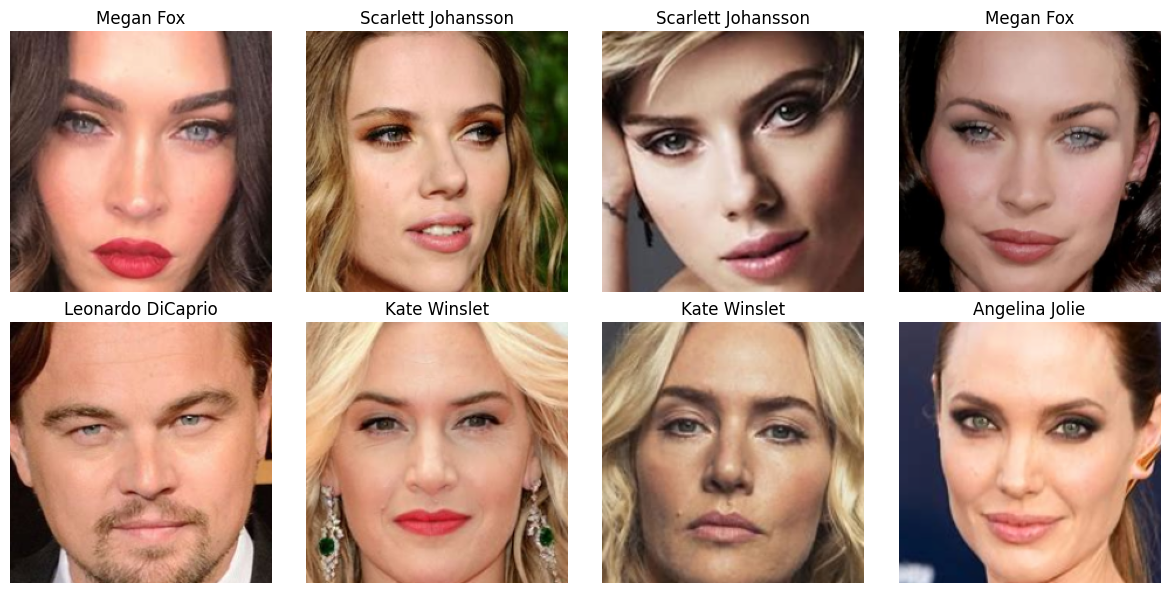

In [11]:
dataiter = iter(train_loader)
images, labels = next(dataiter)


plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    imshow(images[i], title=dataset.classes[labels[i]])
plt.tight_layout()
plt.show()


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18, ResNet18_Weights

class EarlyStopping:
    def __init__(self, patience=2, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False
        self.best_model_wts = None

    def __call__(self, val_acc, model):
        score = val_acc
        if self.best_score is None:
            self.best_score = score
            self.best_model_wts = model.state_dict()
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_wts = model.state_dict()
            self.counter = 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


weights = ResNet18_Weights.IMAGENET1K_V1  
model = resnet18(weights=weights)


num_classes = len(dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

early_stopping = EarlyStopping(patience=2, min_delta=0.001)

num_epochs = 20 

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {train_loss:.4f} - Train Acc: {train_acc:.4f} - Val Acc: {val_acc:.4f}")

    early_stopping(val_acc, model)
    if early_stopping.early_stop:
        print("Early stopping triggered. Stopping training.")
        break

model.load_state_dict(early_stopping.best_model_wts)


Epoch [1/20] - Loss: 1.2160 - Train Acc: 0.6170 - Val Acc: 0.6481
Epoch [2/20] - Loss: 0.2567 - Train Acc: 0.9236 - Val Acc: 0.6481
Epoch [3/20] - Loss: 0.1120 - Train Acc: 0.9745 - Val Acc: 0.7597
Epoch [4/20] - Loss: 0.0873 - Train Acc: 0.9745 - Val Acc: 0.7864
Epoch [5/20] - Loss: 0.0908 - Train Acc: 0.9770 - Val Acc: 0.8301
Epoch [6/20] - Loss: 0.0489 - Train Acc: 0.9891 - Val Acc: 0.8617
Epoch [7/20] - Loss: 0.0161 - Train Acc: 0.9988 - Val Acc: 0.9102
Epoch [8/20] - Loss: 0.0112 - Train Acc: 0.9964 - Val Acc: 0.9417
Epoch [9/20] - Loss: 0.0198 - Train Acc: 0.9939 - Val Acc: 0.7233
Epoch [10/20] - Loss: 0.0509 - Train Acc: 0.9855 - Val Acc: 0.8665
Early stopping triggered. Stopping training.


<All keys matched successfully>

In [13]:
model.load_state_dict(early_stopping.best_model_wts)

torch.save(model.state_dict(), "best_model.pkl")
print("Best model saved as 'best_model.pkl'")

Best model saved as 'best_model.pkl'


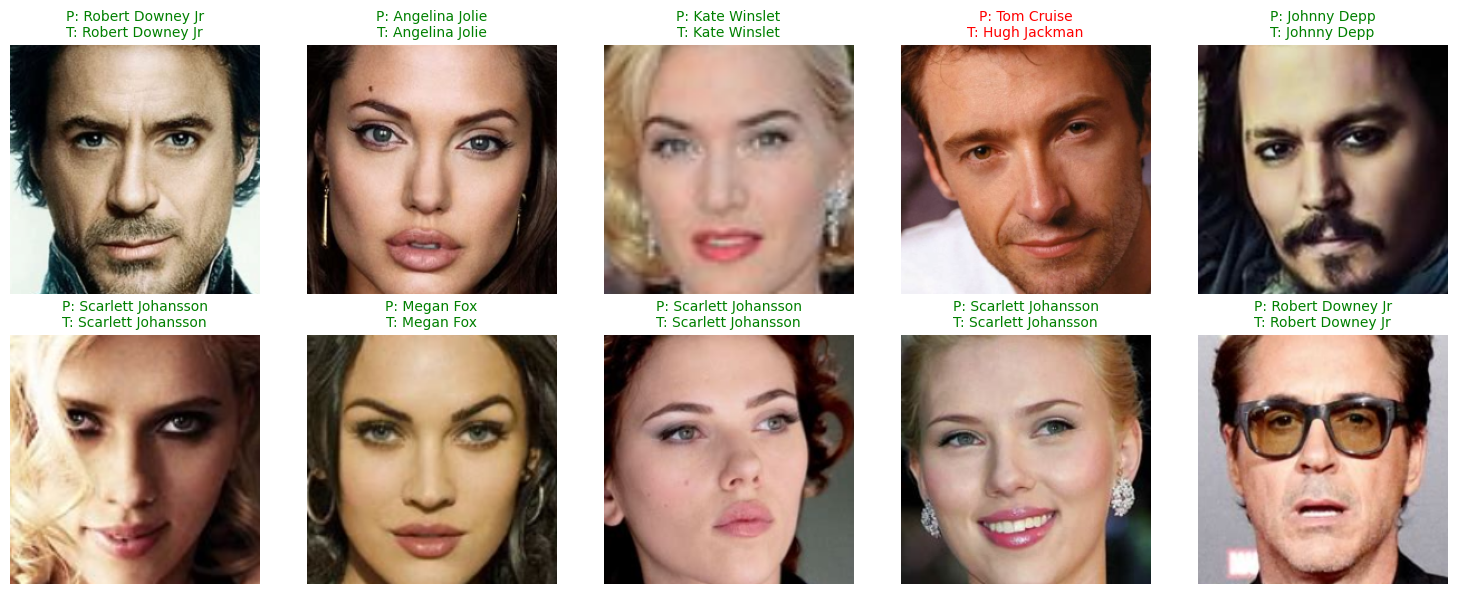

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import random

model.eval()

random_indices = random.sample(range(len(test_dataset)), 10)

def unnormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    return img_tensor * std + mean

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
class_names = dataset.classes

for i, idx in enumerate(random_indices):
    image_tensor, true_label = val_dataset[idx]
    input_tensor = image_tensor.unsqueeze(0).to(device)

 
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted_label = torch.max(output, 1)

    img = unnormalize(image_tensor).numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)

    ax = axes[i // 5, i % 5]
    ax.imshow(img)
    pred_class = class_names[predicted_label.item()]
    true_class = class_names[true_label]
    title_color = 'green' if predicted_label.item() == true_label else 'red'
    ax.set_title(f"P: {pred_class}\nT: {true_class}", color=title_color, fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()
